In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import numpy as np


In [2]:
X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [3]:
pipeline = Pipeline(
    [
        ("imputer", StandardScaler()),
        ("classifier", SVC(random_state=42, probability=True)),
    ]
)

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "classifier__kernel": ["linear", "rbf", "poly"],
    "classifier__C": [0.1, 1, 10, 100],
    "classifier__gamma": ["scale", "auto", 0.01, 0.1],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    cv=skf,
)

grid_search.fit(X_train, y_train)

print(f"Meilleurs parametres : {grid_search.best_params_}")
print(f"Meilleur score CV : {grid_search.best_score_}")

Meilleurs parametres : {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Meilleur score CV : 0.9738878509919948


In [5]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Rapport de classification")
print(classification_report(y_test, y_pred))

Rapport de classification
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



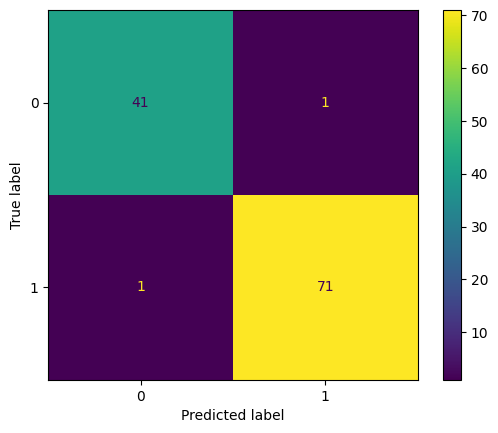

In [6]:
conf_mat = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_mat).plot()

In [7]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

print(f"AUC : {auc}")

AUC : 0.9976851851851851


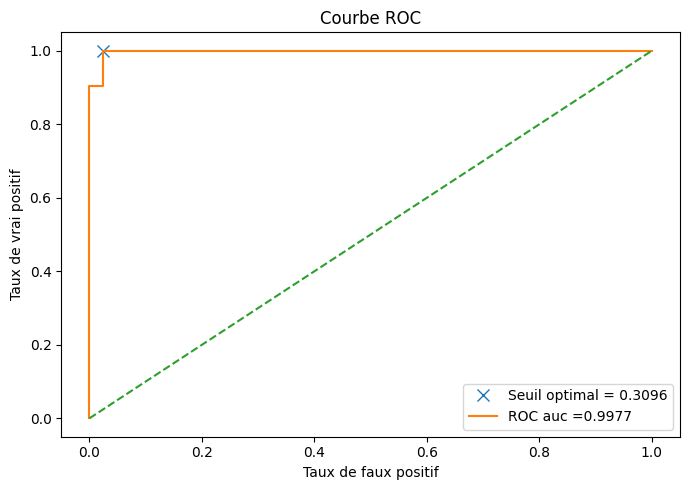

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

axes.plot(
    fpr[optimal_idx],
    tpr[optimal_idx],
    "x",
    markersize=8,
    label=f"Seuil optimal = {optimal_threshold:.4f}",
)

axes.plot(fpr, tpr, label=f"ROC auc ={auc:.4f}")
axes.plot([0, 1], [0, 1], "--")

axes.set_title("Courbe ROC")
axes.set_xlabel("Taux de faux positif")
axes.set_ylabel("Taux de vrai positif")
axes.legend()

plt.tight_layout()
plt.show()

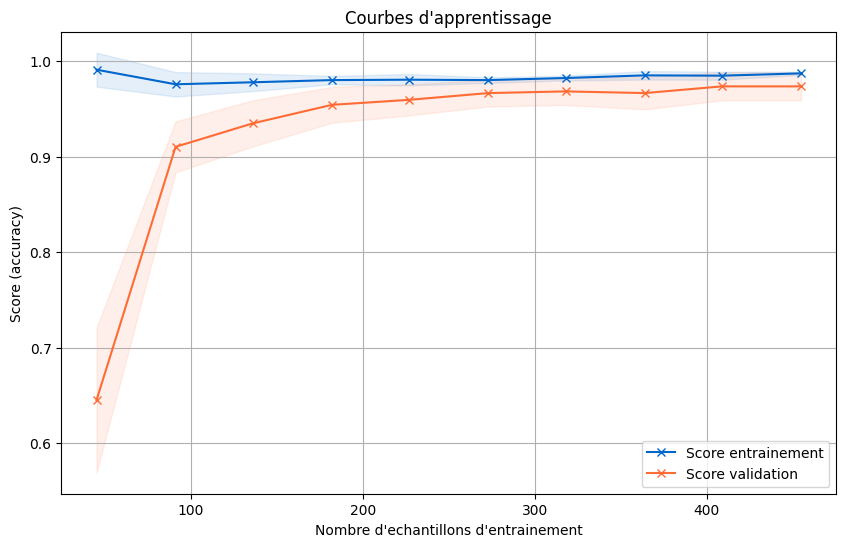

In [13]:
# Calculer les courbes d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    pipeline,
    X,
    y,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="accuracy",
    n_jobs=-1,
)

# Calculer les moyennes et ecarts-types
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Tracer
plt.figure(figsize=(10, 6))
plt.plot(
    train_sizes,
    train_mean,
    "x-",
    label="Score entrainement",
    color="#0066cc",
)
plt.plot(
    train_sizes,
    test_mean,
    "x-",
    label="Score validation",
    color="#ff6b35",
)
plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.1,
    color="#0066cc",
)
plt.fill_between(
    train_sizes,
    test_mean - test_std,
    test_mean + test_std,
    alpha=0.1,
    color="#ff6b35",
)
plt.xlabel("Nombre d'echantillons d'entrainement")
plt.ylabel("Score (accuracy)")
plt.title("Courbes d'apprentissage")
plt.legend()
plt.grid(True)
plt.show()

Synthèse de l’évaluation du modèle de classification :
- Le score F1 obtenu en validation croisée est très élevé $\simeq 0,97$, indiquant un excellent équilibre entre précision et rappel.
- La matrice de confusion met en évidence des performances quasi parfaites, avec seulement un faux négatif (FN) et un faux positif (FP).
- Le score AUC est proche de 1, traduisant une capacité de discrimination presque optimale du modèle.
- La courbe ROC confirme ces excellentes performances, avec une aire sous la courbe quasiment maximale.
- La courbe d’apprentissage montre un bon comportement du modèle, sans signe d’overfitting ni d’underfitting, témoignant une généralisation efficace.